### Lista para lembrar

- Fazer um `pip freeze` para os `requirements.txt`

- usar a pasta `manipulated_data` criado no nosso repositório

- precisa baixar as imagens do *dataset* completo para criar a pasta com as imagens que serão usadas para teste

- precisa do arquivo `used_clothes.csv` do nosso repositório

### Importando bibliotecas

In [1]:
# Importing the Keras libraries and packages
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator

import shutil

Using TensorFlow backend.


### Tratamento dos dados

Fazendo um `value_counts()` da coluna `Details` dos arquivos `csv` utilizados:

In [13]:
print("*" * 40)

for num in [2, 3, 6]:
    print(f"Lendo arquivo {num}_details_categories.csv:\n")

    df = pd.read_csv(f"{num}_details_categories.csv")
    print(df.Details.value_counts())
    print("*" * 40)

print(f"Lendo arquivo used_clothes.csv:\n")

df = pd.read_csv("used_clothes.csv")
print(df.Details.value_counts())
print("*" * 40)

****************************************
Lendo arquivo 2_details_categories.csv:

Solid        2511
Non-solid    2500
Name: Details, dtype: int64
****************************************
Lendo arquivo 3_details_categories.csv:

Pattern      2000
Solid        1946
Geometric    1885
Name: Details, dtype: int64
****************************************
Lendo arquivo 6_details_categories.csv:

Pattern         1500
Floral          1500
Solid           1400
Stripes         1188
Checkers         697
Animal print     560
Name: Details, dtype: int64
****************************************
Lendo arquivo used_clothes.csv:

Pattern         1500
Floral          1500
Solid           1400
Stripes         1188
Checkers         697
Animal print     560
Name: Details, dtype: int64
****************************************


Criando pastas com as imagens a serem usadas para treino e teste

In [135]:
def create_test_dataset(csv_filename: str, default_csv_filename: str = "manipulated_data/initial_filtered_clothes.csv", images_path: str = "images") -> list:

    file_list = pd.read_csv(csv_filename)["file_name"].tolist()
    default_list = pd.read_csv(default_csv_filename)["file_name"].tolist()

    test_clothes_list = []

    for img in os.listdir(images_path):
        if img not in file_list and img in default_list:
            test_clothes_list.append(img)

    return test_clothes_list[:len(file_list)//2]

def create_folder_dataset(test_dataset: list, dest_path: str, src_path: str = "images") -> pd.DataFrame:
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)

        print(f"-> Folder {dest_path} created successfully")
    else:
        print(f"-> Folder {dest_path} already exists")

    for img in test_dataset:
        src = os.path.join(src_path, img)
        dest = os.path.join(dest_path, img)

        if os.path.exists(src):
            shutil.copy(src, dest)
        else:
            print(f"-> File not found: {img}")
    
    return pd.DataFrame({"file_name": test_dataset})

def create_model(summary: bool = False) -> Sequential:
    # Criando o classificador
    classifier = Sequential()

    # Step 1 - Convolution
    classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) # por padrão kernel_size é (3, 3)

    # Step 2 - Pooling
    classifier.add(MaxPooling2D(pool_size = (2, 2))) # por padrão pool_size é (2, 2)

    # Adding a second convolutional layer
    classifier.add(Conv2D(32, (3, 3), activation = 'relu')) # por padrão kernel_size é (3, 3)
    classifier.add(MaxPooling2D(pool_size = (2, 2))) # por padrão pool_size é (2, 2)

    # Step 3 - Flattening
    classifier.add(Flatten())

    # Step 4 - Full connection
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dense(units = 6, activation = 'softmax'))

    # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    if summary:
        classifier.summary()

    return classifier

def fitting(test_dataframe: pd.DataFrame, train_image_path: str, test_image_path: str) -> tuple:
    train_datagen = ImageDataGenerator(rescale=1. / 255)

    test_datagen = ImageDataGenerator(rescale = 1. / 255)

    training_set = train_datagen.flow_from_directory(train_image_path,
                                                    target_size=(64, 64),
                                                    batch_size=16,
                                                    class_mode='categorical')

    test_set = test_datagen.flow_from_dataframe(dataframe=test_dataframe,
                                                directory=test_image_path,
                                                x_col='file_name',
                                                class_mode=None,
                                                target_size=(64, 64),
                                                batch_size=16,
                                                shuffle=False)
    
    return training_set, test_set

def save_model(classifier: Sequential, model_name: str):
    model_json = classifier.to_json()
    with open(f"model_{model_name}.json", "w") as json_file:
        json_file.write(model_json)

    classifier.save_weights(f"model_{model_name}.h5")
    print(f"-> Model saved successfuly in file model_{model_name}.h5")

In [57]:
used_clothes_list = pd.read_csv("2_details_categories.csv").file_name.tolist()
initial_filtered_clothes_list = pd.read_csv("manipulated_data/initial_filtered_clothes.csv").file_name.tolist()

In [58]:
test_clothes_list = []

for img in os.listdir('images'):
    if img not in used_clothes_list and img in initial_filtered_clothes_list:
        test_clothes_list.append(img)

In [17]:
test_dataset = test_clothes_list[:len(used_clothes_list)//2]

Lembrar de apagar a pasta para não dar problema de criar muitas imagens (resolver)

In [ ]:
if not os.path.exists("dataset_test"):
    os.makedirs("dataset_test")

    print("-> Folder dataset_test created successfully")
else:
    print("-> Folder dataset_test already exists")

for img in test_dataset:
    src_path = os.path.join("images", img)
    dest_path = os.path.join("dataset_test", img)

    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        print(f"-> File not found: {img}")

-> Folder dataset_test already exists


In [20]:
test_dataframe = pd.DataFrame({"file_name": test_dataset})

### Modelo

Criando o modelo

In [21]:
# Criando o classificador
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) # por padrão kernel_size é (3, 3)

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2))) # por padrão pool_size é (2, 2)

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu')) # por padrão kernel_size é (3, 3)
classifier.add(MaxPooling2D(pool_size = (2, 2))) # por padrão pool_size é (2, 2)

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 6, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [63]:
# Descomentar para visualizar a quantidade de parâmetros em cada camada da CNN 
# classifier.summary()

### Realizando o fitting

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('manipulated_data/images',
                                                 target_size=(64, 64),
                                                 batch_size=16,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_dataframe(dataframe=test_dataframe,
                                            directory='dataset_test',
                                            x_col='file_name',
                                            class_mode=None,
                                            target_size=(64, 64),
                                            batch_size=16,
                                            shuffle=False)

Found 6845 images belonging to 6 classes.
Found 2505 validated image filenames.


In [14]:
def create_dataset(csv_filename: str, column, original_csv_filename: str = "manipulated_data/initial_filtered_clothes.csv", images_path: str = "images") -> list:

    file_list = pd.read_csv(csv_filename)[column].tolist()
    original_list = pd.read_csv(original_csv_filename)[column].tolist()

    aux_list = []

    for img in os.listdir(images_path):
        if img not in file_list and img in original_list:
            aux_list.append(img)

    return aux_list[:len(file_list)//2]

In [141]:
def create_train_dict(csv_filename: str):
    df_file = pd.read_csv(csv_filename)

    try:
        df_file.drop("Unnamed: 0", axis=1, inplace=True)
    except:
        pass

    df_file1 = df_file.loc[:, df_file.columns.isin(["file_name", "Details"])]

    rel_dict = {}

    df_file_dict = df_file1.to_dict()

    for i in range(len(df_file_dict["Details"])):
        rel_dict[df_file_dict["file_name"][i]] = df_file_dict["Details"][i]

    return rel_dict, df_file1

def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

        print(f"-> Folder {folder_path} created successfully")
    else:
        print(f"-> Folder {folder_path} already exists")

def create_folder_train_dataset(rel_dict: dict, foldername: str, src_path: str = "images"):
    for img, category in rel_dict.items():
        category1 = category.lower().replace("-", "_")
        
        src = os.path.join(src_path, img)
        dest = os.path.join(f"{foldername}/{category1}", img)

        if os.path.exists(src):
            shutil.copy(src, dest)
        else:
            print(f"-> File not found: {img}")

def create_test_dataset(csv_filename: str, default_csv_filename: str = "manipulated_data/initial_filtered_clothes.csv", images_path: str = "images") -> list:

    file_list = pd.read_csv(csv_filename)["file_name"].tolist()
    default_list = pd.read_csv(default_csv_filename)["file_name"].tolist()

    test_clothes_list = []

    for img in os.listdir(images_path):
        if img not in file_list and img in default_list:
            test_clothes_list.append(img)

    return test_clothes_list[:len(file_list)//2]

def create_folder_dataset(test_dataset: list, dest_path: str, src_path: str = "images") -> pd.DataFrame:
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)

        print(f"-> Folder {dest_path} created successfully")
    else:
        print(f"-> Folder {dest_path} already exists")

    for img in test_dataset:
        src = os.path.join(src_path, img)
        dest = os.path.join(dest_path, img)

        if os.path.exists(src):
            shutil.copy(src, dest)
        else:
            print(f"-> File not found: {img}")
    
    return pd.DataFrame({"file_name": test_dataset})

def create_model(num_categories: int, summary: bool = False) -> Sequential:
    # Criando o classificador
    classifier = Sequential()

    # Step 1 - Convolution
    classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) # por padrão kernel_size é (3, 3)

    # Step 2 - Pooling
    classifier.add(MaxPooling2D(pool_size = (2, 2))) # por padrão pool_size é (2, 2)

    # Adding a second convolutional layer
    classifier.add(Conv2D(32, (3, 3), activation = 'relu')) # por padrão kernel_size é (3, 3)
    classifier.add(MaxPooling2D(pool_size = (2, 2))) # por padrão pool_size é (2, 2)

    # Step 3 - Flattening
    classifier.add(Flatten())

    # Step 4 - Full connection
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dense(units = num_categories, activation = 'softmax'))

    # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    if summary:
        classifier.summary()

    return classifier

def fitting(test_dataframe: pd.DataFrame, train_image_path: str, test_image_path: str) -> tuple:
    train_datagen = ImageDataGenerator(rescale=1. / 255)

    test_datagen = ImageDataGenerator(rescale = 1. / 255)

    training_set = train_datagen.flow_from_directory(train_image_path,
                                                    target_size=(64, 64),
                                                    batch_size=16,
                                                    class_mode='categorical')

    test_set = test_datagen.flow_from_dataframe(dataframe=test_dataframe,
                                                directory=test_image_path,
                                                x_col='file_name',
                                                class_mode=None,
                                                target_size=(64, 64),
                                                batch_size=16,
                                                shuffle=False)
    
    return training_set, test_set

def save_model(classifier: Sequential, model_name: str):
    model_json = classifier.to_json()
    with open(f"model_{model_name}.json", "w") as json_file:
        json_file.write(model_json)

    classifier.save_weights(f"model_{model_name}.h5")
    print(f"-> Model saved successfuly in file model_{model_name}.h5")

In [133]:
csv_list = ["3_details_categories.csv"]

In [142]:
for csv_file in csv_list:
    # Treino
    train_dict, df_file1 = create_train_dict(csv_file)

    create_folder(f"dataset_train_{csv_file[0]}")

    categories_list = [cat.lower().replace("-", "_") for cat in df_file1["Details"].value_counts().keys()]

    for category in categories_list:
        create_folder(f"dataset_train_{csv_file[0]}/{category}")

    create_folder_train_dataset(train_dict, f"dataset_train_{csv_file[0]}")

    # Teste
    test_dataset = create_test_dataset(csv_file)
    test_dataframe = create_folder_dataset(test_dataset, f"dataset_test_{csv_file[0]}")
    
    classifier = create_model(num_categories=int(csv_file[0])) # mudar para receber o tamanho da camada Dense

    training_set, test_set = fitting(test_dataframe, train_image_path=f"dataset_train_{csv_file[0]}", test_image_path=f"dataset_test_{csv_file[0]}")
    
    history = classifier.fit(training_set, steps_per_epoch=800, epochs=5)
    
    save_model(classifier, f"dataset_test_{csv_file[0]}")

-> Folder dataset_train_3 already exists
-> Folder dataset_train_3/pattern already exists
-> Folder dataset_train_3/solid already exists
-> Folder dataset_train_3/geometric already exists
-> Folder dataset_test_3 already exists
Found 4932 images belonging to 3 classes.
Found 2915 validated image filenames.
Epoch 1/5
 85/800 [==>...........................] - ETA: 2:12 - loss: 1.0478 - accuracy: 0.4478

KeyboardInterrupt: 

In [ ]:
history = classifier.fit(training_set, steps_per_epoch=800, epochs=5)

Epoch 1/5
800/800 [==============================] - 190s 237ms/step - loss: 1.5089 - accuracy: 0.3755
Epoch 2/5
800/800 [==============================] - 156s 196ms/step - loss: 1.1290 - accuracy: 0.5671
Epoch 3/5
800/800 [==============================] - 151s 189ms/step - loss: 0.7064 - accuracy: 0.7478
Epoch 4/5
800/800 [==============================] - 157s 197ms/step - loss: 0.4170 - accuracy: 0.8615
Epoch 5/5
800/800 [==============================] - 161s 202ms/step - loss: 0.2358 - accuracy: 0.9250


### Salvando o modelo em um arquivo

In [26]:
# Salvando o modelo em um JSON
model_json = classifier.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Salvando os pesos em um arquivo HDF5
classifier.save_weights("model.h5")
print(f"-> Model saved successfuly in file model.h5")

Saved model to disk


### Testando o modelo com uma imagem

In [ ]:
import numpy as np
from keras.preprocessing import image

test_image = image.load_img('dataset_test/052757039aa045e7b996c46c83848bdf.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

result = classifier.predict(test_image)

{'animal_print': 0,
 'checkers': 1,
 'floral': 2,
 'pattern': 3,
 'solid': 4,
 'stripes': 5}

In [50]:
index = np.where(result[0] == 1)[0][0]
index

2

In [51]:
list(training_set.class_indices.keys())[list(training_set.class_indices.values()).index(index)]

'floral'

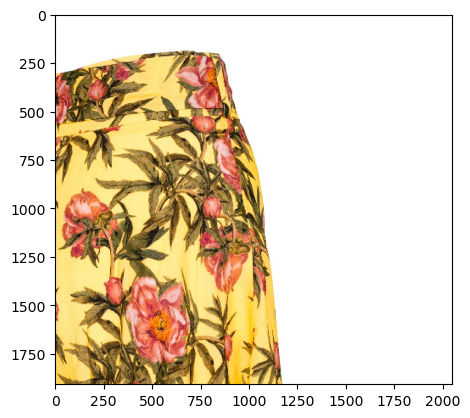

In [52]:
img = cv2.imread('dataset_test/052757039aa045e7b996c46c83848bdf.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))